In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../environments/'); import gw; import gp

import experiment as expt
import torch
import uuid
import pickle 
import csv

### Environment

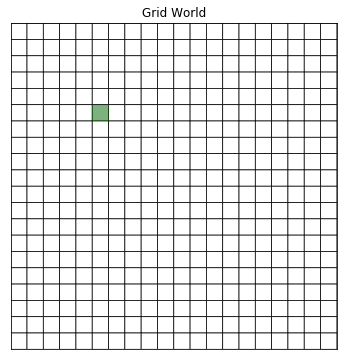

In [11]:
# set environment parameters
rows, columns = 20,20
env_type = None
penalty = -0.01
reward_location = (5,5)
rho = 0.0

# generate environment object
env = gw.GridWorld(rows=rows,cols=columns,env_type=env_type,
                   rewards = {reward_location:1},
                   step_penalization=penalty,
                   rho=rho,
                   actionlist = ['Down', 'Up', 'Right', 'Left'],
                   rewarded_action=None)

# plot environment
fig = gp.plotWorld(env, scale=0.3)

### Agent - Model Free Actor Critic + Episodic Module

In [42]:
# agent parameters    
training = {
    'load_model':  False,
    'load_dir':    '',
    
    'architecture': 'A',
    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','conv', 'pool', 'linear','linear'],
    'hidden_dims': [None, None, None, None, 100, 200],
    
    'freeze_w':    False,

    'rfsize':      5,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      False
}

testing_1 = training.copy()
testing_1.update({'load_model':True, 'freeze_w':True})

testing_2 = testing_1.copy()
testing_2.update({'use_EC':True})

testing_4 = testing_1.copy()
testing_4.update({'freeze_w':False})

testing_5 = testing_4.copy()
testing_5.update({'use_EC':True})

params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

### Experiment

In [37]:
# experiment parameters
experiment_type = 0

NUM_TRIALS = 2000
NUM_EVENTS = 100

# mixing parameters for MF-EC control
alpha = 0.01 # MF confidence boost for reward
beta = 100 # MF confidence decay - number of steps to decay to 1% 

In [39]:
reload(ec)
# create an agent with parameters for a given experiment type
agent_params = params[experiment_type]
load_weights = False

if experiment_type is not 0 and load_weights: 
    id_key = input('Weights to load: ')
    agent_params['load_dir'] = f'../data/outputs/gridworld/weights/{id_key}.pt'

# create agent from parameters for given experiment type
agent = ac.make_agent(agent_params)

# create experiment object
ex = expt.test_expt(agent, env, use_mem=agent_params['use_EC'])

# run experiment
ex.run(NUM_TRIALS, NUM_EVENTS, alpha=alpha,beta=beta)

0: -1.0000000000000007 (0.2562582492828369s)
200: -1.0000000000000007 (60.399959325790405s)
400: -1.0000000000000007 (58.20622229576111s)
600: -1.0000000000000007 (56.377989053726196s)
800: -1.0000000000000007 (56.57574439048767s)
1000: -1.0000000000000007 (58.141353607177734s)
1200: -1.0000000000000007 (56.80613088607788s)
1400: -1.0000000000000007 (56.13208532333374s)
1600: 0.84 (54.61280012130737s)
1800: -1.0000000000000007 (54.454034090042114s)
1999: -1.0000000000000007 (50.441683292388916s)


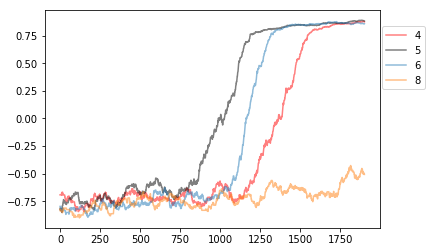

In [41]:
smoothing = 100

rf8 = ex.data['total_reward']
plt.plot(gp.running_mean(rf4, smoothing), 'r', alpha=0.5, label='4')
plt.plot(gp.running_mean(rf5, smoothing), 'k', alpha=0.5, label ='5')
plt.plot(gp.running_mean(rf6, smoothing), alpha=0.5, label='6')
plt.plot(gp.running_mean(rf8, smoothing), alpha=0.5, label='8')
plt.legend(bbox_to_anchor=(1.15,0.95))

In [ ]:
def data_log(run_id, experiment_type, experiment, **kwargs):
    load_from = kwargs.get('load_from',' ')
    expt_log = [
    'save_id',          #uuid
    'experiment_type',  #int
    'load_from',        #str
    'num_trials',       #int
    'num_events',       #int
    'ENVIRONMENT',      #str
    'shape',            #tuple 
    'rho',              #float
    'rewards',          #dict
    'action_list',      #list
    'rwd_action',       #str
    'step_penalization',#float
    'useable',          #list
    'obstacle2D',       #list
    'terminal2D',       #list
    'jump',             #list or NoneType
    'random_start',     #bool
    'AGENT',            #arch 
    'use_SR',           #bool
    'freeze_weights',   #bool
    'layers',           #list
    'hidden_types',     #list
    'gamma',            #float
    'eta',              #float
    'optimizer',        #torch optim. class
    'MEMORY', #         # string* 
    'cache_limit',      #int
    'use_pvals',        #bool
    'memory_envelope',  #int
    'mem_temp',         #float
    'alpha',            #float   # memory mixing parameters
    'beta'              #int
    ]
    write = kwargs.get('write', False)  
    
    
    
    log_jam = [
        run_id,
        experiment_type, 
        load_from,
        experiment.num_trials,
        experiment.num_events,
        
        str(experiment.env.maze_type), # 'ENVIRONMENT'
        experiment.env.shape,
        float(experiment.env.rho),
        experiment.env.rewards,
        experiment.env.action_list,
        str(experiment.env.rwd_action),
        experiment.env.step_penalization,
        experiment.env.useable,
        experiment.env.obstacle2D,
        experiment.env.terminal2D,
        str(experiment.env.jump),
        experiment.env.random_start,
        
        experiment.agent_architecture, #'AGENT'
        experiment.agent.use_SR,
        experiment.agent.optimizer.param_groups[0]['lr'] == 0.0, # evaluates true if frozen weights
        experiment.agent.layers,
        experiment.agent.hidden_types,
        experiment.agent.gamma,
        experiment.agent.eta,
        experiment.agent.optimizer,
        
        str(experiment.episodic)
    ]
    
    if experiment.episodic is not None: 
        epi_log = [
            experiment.episodic.cache_limit,
            experiment.episodic.use_pvals,
            experiment.episodic.mem_temp,
            experiment.alpha,
            experiment.beta
        ]
        log_jam += epi_log
    for i in log_jam:
        print(i, type(i))
    if write:
        parent_folder = '../data/outputs/gridworld/E2'
        # write to logger
        with open(f'{parent_folder}/experiments_log.csv', 'a+', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(log_jam)
        
        # save environment
        if experiment_type == 0: 
            pickle.dump(experiment.env, open(f'{parent_folder}/environments/{save_id}_env.p', 'wb'))
        
        # save agent
        torch.save(experiment.agent, f'{parent_folder}/agent_weights/{save_id}.pt')
        # save data
        pickle.dump(experiment.data, open(f'{parent_folder}/results/{save_id}_data.p', 'wb'))
        # save memory
        if experiment.episodic is not None:
            pickle.dump(experiment.episodic, open(f'{parent_folder}/episodic_memory/{save_id}_EC.p', 'wb'))
        
        
        
    
        
data_log(save_id, ex)

In [ ]:
env.rewards = {(5,15):1}
env.buildRewardFunction()
fig = gw.plotWorld(env, scale=0.3, four_actions=(len(env.action_list) == 4))

In [ ]:
print([agent.optimizer.param_groups[x]['lr'] for x in range(len(agent.optimizer.param_groups))])
print(ex.episodic)
print(agent_params['use_EC'])

# Create Environment




In [ ]:
reload(expt)

alphas = np.arange(1,6)*0.1
betas = np.arange(0,50,10)
betas[0] =1 

experiment_type = 0
if experiment_type is not 0: 
    id_key = input('Weights to load: ')
    agent_params[experiment_type]['load_dir'] = f'../data/outputs/gridworld/weights/{id_key}.pt',
    print(agent_params[experiment_type]['load_dir'])

    
for j in range(1):
    for alpha in alphas:
        for beta in [5]:
            print(f'alpha:{alpha},beta:{beta}')
            # generate agent from given parameters
            agent = ac.make_agent(agent_params[experiment_type])
            print(agent)

            

            # get unique ID tag for this run
            save_id = uuid.uuid4()

            ex = expt.test_expt(agent, env, use_mem=agent_params[experiment_type]['use_EC'])
            #ex.run(NUM_TRIALS, 50, data, alpha=alpha,beta=beta)


            if agent_params[experiment_type]['use_EC']:
                mem = ex.episodic
            else:
                mem = None
            if agent.use_SR:
                arch = 'B'
            else: 
                arch = 'A'
                
            #expt.log_experiments(save_id, experiment_type, 
            #                     env, agent, data, mem, 
            #                     save_flag = True, 
            #                     load=agent_params[experiment_type]['load_dir'], arch = arch,
            #                    alpha=alpha, beta=beta)


In [ ]:
smoothing = 30
plt.figure()
plt.plot(gp.running_mean(data['total_reward'],smoothing),'pink')
plt.title('Smoothed Reward Per Trial')
plt.show()
plt.close()

plt.figure()
#plt.plot(gp.running_mean(data['loss'][0],smoothing), 'darkgreen', label='$\pi$')
#plt.plot(gp.running_mean(data['loss'][1],smoothing), 'lightgreen', label='v')
plt.plot(gp.running_mean(data['loss'][2],smoothing), 'cyan', label='$\phi$')
plt.legend(loc=0)
plt.title('Smoothed Loss')
plt.show()
plt.close()

In [ ]:
reload(expt)

sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
gp.plot_pref_pol(env, pol_grid, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)
gp.plot_polmap(env, pol_grid, threshold = 0.22)
gp.plot_valmap(env, val_grid, v_range = [0,50])

In [ ]:
print(data['trials_run_to_date'])

In [ ]:
save = f'../data/outputs/gridworld/weights/{save_id}.pt'
ac.torch.save(agent,save)

In [ ]:
reload(gp)
def ec_policies(maze, EC, trial_timestamp,**kwargs):
    envelope = kwargs.get('decay', 50)
    mem_temp = kwargs.get('mem_temp', 1)
    mpol_array = np.zeros(maze.grid.shape, dtype=[(x, 'f8') for x in maze.action_list])
    
    # cycle through readable states
    for key in EC.cache_list.keys():
        row, col = EC.cache_list[key][2]
        pol = EC.recall_mem(key, timestep = trial_timestamp, mem_temp = mem_temp, print_t=False)
        mpol_array[row,col] = tuple(pol)
        
    return mpol_array
        

abcd = ec_policies(env,ex.episodic, trial_timestamp = 0, mem_temp = 0.5)


In [ ]:
reload(gp)
gp.plot_pref_pol(env, abcd, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)

In [ ]:
state = (4,3)
env.set_state(env.twoD2oneD(state))
observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))
policy_, value_, phi_, psi_ = agent(observation)

lin_act = tuple(np.round(phi_.data[0].numpy(),4))
key, sim = ex.episodic.cosine_sim(lin_act)

mem_state = ex.episodic.cache_list[key]

In [ ]:
print(mem_state)
print(ex.episodic.recall_mem(lin_act, timestep=0))
#print(abcd[state])
plt.bar(np.arange(4),ex.episodic.recall_mem(lin_act, timestep=0))
#MF_alone = data

In [ ]:
ex.mem_temp

## junkyard

In [ ]:
# random events 
sig = 0.8
rewards = np.array([np.random.choice([0,1], p=[sig, 1-sig]) for x in range(100)], dtype=float)
rewards[np.where(rewards==0)] = -0.01

print(rewards)

def poops(x, alpha, beta):    
    toots = alpha*np.exp(-np.arange(len(x))/beta) # exponential decay with time 
    poops = np.convolve(toots,x, mode='full')[0:len(x)]
    return poops

def turds(x, alpha, beta):
    #alpha = bump size
    # beta = number of steps to decay to 0.01
    threshold = 0.01
    decay = np.power(threshold,1/beta)
    a = np.empty_like(x, dtype=float)
    
    for ind, i in enumerate(x):
        if ind == 0:
            a[ind] = i*alpha
        else:
            calc = decay*a[ind-1] + i*alpha
            if calc > 1:
                calc = 1
            a[ind] = calc
    return a

alphas = np.arange(1,6)*0.1
betas = np.arange(0,50,10)
betas[0] = 1
## iterate over alphas: 
fig, ax = plt.subplots(len(alphas), 1, sharex=True, sharey=True)
for xx, i in enumerate(alphas):
    for j in betas:
        pp = turds(rewards,alpha=i,beta=j)
        ax[xx].plot(rewards,'k|')
        ax[xx].plot(pp,label=f'b={j}')
        ax[xx].set_ylabel(f'a={np.round(i,2)}')
        
ax[0].legend(bbox_to_anchor=(1.05,0.95))
plt.show()
plt.close()

# iterate over betas:
fig, ax = plt.subplots(len(betas),1, sharex=True, sharey=True)
for yy, j in enumerate(betas):
    for i in alphas:
        pp = turds(rewards,alpha=i, beta=j)
        ax[yy].plot(rewards,'k|')
        ax[yy].plot(pp,label=f'a={i}')
        ax[yy].set_ylabel(f'b={np.round(j,2)}')
ax[0].legend(bbox_to_anchor=(1.05,0.95))
plt.show()
plt.close()